<a href="https://www.kaggle.com/code/orimeidler/are-sequel-movies-really-worse?scriptVersionId=106677524" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h2 id="Prelude">Prelude</h2>

In this project I will try to investigate the sophomore slump in movies. In short, ["sophomore slump"](https://en.wikipedia.org/wiki/Sophomore_slump) or "sophomore jinx" referes to a case in which the second year or effort fails to achive the high results of the first effort. In this project I will use metrics of rating in IMDb in order to understand if the sequel movies are greater\same\worse than their younger sibilings. 

**Work Plan**

0. Install and import packges.
1. Organize the Data - web scrapping IMDb pages to get samples of first and second movies (sequeles) and web scarpping Wikipedia as well in order to expend the sample.
2. A little EDA (Explnatory data analysis) - just to make sure the sample is looking diverse in terms of genres and years. 
3. Statisitcs Interfence - declare the hypothesis and try to prove it.   
4. Summary`

<h2 id="Install-packges-and-import">Install packges and import</h2>


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdbopensource/title.basics.tsv/data.tsv
/kaggle/input/imdbopensource/title.episode.tsv/data.tsv
/kaggle/input/imdbopensource/title.principals.tsv/data.tsv
/kaggle/input/imdbopensource/title.ratings.tsv/data.tsv
/kaggle/input/imdbopensource/name.basics.tsv/data.tsv
/kaggle/input/imdbopensource/title.akas.tsv/data.tsv
/kaggle/input/imdbopensource/title.crew.tsv/data.tsv
/kaggle/input/movies-year-imdb-sequals/movies_imdb.csv


In [2]:
#install packges 
!pip install Beaustifulsoap
!pip install wikipedia

ERROR: Could not find a version that satisfies the requirement Beaustifulsoap (from versions: none)
ERROR: No matching distribution found for Beaustifulsoap
  Preparing metadata (setup.py) ... - done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11695 sha256=4d45ede1bd5645e3f092eea4b9f217eca957054c2ece6484327b3bc19e103cf3
  Stored in directory: /root/.cache/pip/wheels/15/93/6d/5b2c68b8a64c7a7a04947b4ed6d89fb557dcc6bc27d1d7f3ba
Successfully built wikipedia


In [3]:
#improt requsted packges 
import wikipedia
from urllib.request import urlopen
import re
from bs4 import BeautifulSoup
import nltk
import matplotlib.pyplot as plt
import math
from itertools import chain
from scipy.stats import norm

<h2 id="Orginazing-the-Data">Orginazing the Data</h2>

<span style="color:red">This is a very long and technical part (although interesting in my opinion) - consider jumping to the </span>
[next section](#A-little-EDA)
<span style="color:red"> if this is not interesting to you. </span>

First of all I downloaded IMDb free data and upload it to kaggle - the data is from this [link](https://datasets.imdbws.com/).

The downloaded information is courtesy of IMDb (https://www.imdb.com). Used with permission.


In [4]:
# load the data into temporery df's
basics_df,rating_df =pd.read_csv("/kaggle/input/imdbopensource/title.basics.tsv/data.tsv",sep="\t",low_memory=False ), pd.read_csv("/kaggle/input/imdbopensource/title.ratings.tsv/data.tsv",sep="\t",low_memory=False)

# the project is only on movies, filter the df
basics_df= basics_df[basics_df["titleType"]=="movie"] 

# merge to get only the requseted rows and get the requsted columns
movies_df = pd.merge(basics_df,rating_df ,on = "tconst")

I searched the web to get a starting point about movies with sequels.

I found out about two useful resources.

The first one is a long list of movies with their sequels in IMDb lists ([link](https://www.imdb.com/list/ls003495084/)).
The problem with this resource is that there is no differenciation between one movie series to the other.

First of all, I will download the data from IMDb and continue filtering and validating using the second resource. 


In [5]:
def search_web(l_item:str,what_serach:str)->str:
    """
    l_item: prettify HTML to search in
    what_serach: regex expression
    return: in case the item is found it returns the first oucorunce
    """
    # There are some cases in which there is no year in the list (movies that haven't come out yet), in this case return None
    try: 
            return re.search(what_serach, str(l_item)).group() 
    except:
        return None   
    

def get_films_list(base_url:str,url_2:str)->(list,str):
    """
    base_url:the base url in the imdb list
    url_2: the specific url for the current page of the list
    return: 
        all list: list of lists with [[movie name,year]...]
        next_page_url: the next url_2 in the next page of the list
    """
    response = urlopen(base_url+url_2)
    html_doc = response.read()
    
    # Parse the html file
    soup = BeautifulSoup(html_doc, 'html.parser')
    
    # Format the parsed html file
    strhtm = soup.prettify()
    
    # Getting all the relevant div
    l = soup.find_all("h3", {"class": "lister-item-header"})
    
    # Search using search_web function and get the movie name and year, in case there is no year don't store the movie name
    all_list = [[search_web(l_item,'(?<=">).*(?=</a>)') ,search_web(search_web(l_item,'(?<=unbold">\().*(?=.*\)</span>)'),"\d{4}") ] for l_item in l if not (search_web(l_item,'(?<=unbold">\().*(?=.*\)</span>)') is None ) ]
    
    # Get the next page url 
    next_page_url = soup.find_all("a", {"class": "flat-button lister-page-next next-page"})
    if next_page_url !=[]: # In case there is no next page element don't search it  
        next_page_url = re.search('(?<=href=").*(?=")', str(next_page_url[0])).group()
    return all_list,next_page_url


all_list = [] 
url,url_2 ="https://www.imdb.com", "/list/ls003495084/"
while url_2!=[]: # in case url url_2 is empty it means we got to the last page then stop
    print("now moving to:",url_2)
    list_this_pag,url_2 = get_films_list(url,url_2)
    all_list=list_this_pag+all_list # append to the main list
    
    
print("finished")

now moving to: /list/ls003495084/
now moving to: /list/ls003495084/?page=2
now moving to: /list/ls003495084/?page=3
now moving to: /list/ls003495084/?page=4
now moving to: /list/ls003495084/?page=5
now moving to: /list/ls003495084/?page=6
now moving to: /list/ls003495084/?page=7
now moving to: /list/ls003495084/?page=8
now moving to: /list/ls003495084/?page=9
now moving to: /list/ls003495084/?page=10
now moving to: /list/ls003495084/?page=11
now moving to: /list/ls003495084/?page=12
finished


Convert the list of lists we scrapped into df and check it out

In [6]:
scrp_movies_df = pd.DataFrame(all_list, columns = ['movie_name', 'year'])
scrp_movies_df.head()

,movie_name,year
0,The Conjuring,2013
1,The Conjuring 2,2016
2,The Conjuring: The Devil Made Me Do It,2021
3,Angry Birds,2016
4,The Angry Birds Movie 2,2019


We can see it looks pretty good. We got the movies in the order of the list. However, the main problem is that we don't know when exactly the series ends -  e.g. row 3.

I will make some cosmetics changes in the df and create another column with the previous movie name - I will use this to check the connection between different rows (so that I can see if they are in the same series or not).

My plan is to check the connection using a word indicator - if there is a similar word in the movie's names, then they are probably related. So, I created the columns "name_without_stop" and "name_next_without_stop". My original plan was to delete all the [stop words](https://www.kaggle.com/datasets/rowhitswami/stopwords) in those columns, because they can create confusion and attachment of unrelated movies. However, there are some movies that contain only stop words (e.g. "It") so I decided to delete a smaller stop words group.

In [7]:
scrp_movies_df["movie_name"] = scrp_movies_df["movie_name"].replace({"&amp;":"&"},regex=True) #change &amp; to &

# Create columns with the previous movie names and years
scrp_movies_df["next_movie"]=scrp_movies_df["movie_name"][1:].append(pd.Series([None])).reset_index(drop=True).replace({"&amp;":"&"},regex=True)
scrp_movies_df["next_movie_year"]= scrp_movies_df["year"][1:].append(pd.Series([None])).reset_index(drop=True)

# Create columns with the current row movie name and previous one with lower characters  and with changes in symbols
scrp_movies_df["name_without_stop"]=  scrp_movies_df["movie_name"].str.lower().replace({"the":"","-":" ","'s":""},regex=True)
scrp_movies_df["name_next_without_stop"]= scrp_movies_df["next_movie"].str.lower().replace({"the":"","-":" ","'s":""},regex=True)

scrp_movies_df.head()

,movie_name,year,next_movie,next_movie_year,name_without_stop,name_next_without_stop
0,The Conjuring,2013,The Conjuring 2,2016,conjuring,conjuring 2
1,The Conjuring 2,2016,The Conjuring: The Devil Made Me Do It,2021,conjuring 2,conjuring: devil made me do it
2,The Conjuring: The Devil Made Me Do It,2021,Angry Birds,2016,conjuring: devil made me do it,angry birds
3,Angry Birds,2016,The Angry Birds Movie 2,2019,angry birds,angry birds movie 2
4,The Angry Birds Movie 2,2019,It,2017,angry birds movie 2,it


As we can see we got what we wanted :) 

In this cell, I will try to understand if the current movie and the previous one are from the same series.

As mentioed I tried to delete all the stop words, but it seems like the title of the movie is many times combined just with stop words. After this, I tried to use a similarity check that if a word is common in the previous and the current row movie name I will consider it a series. It worked fine*. 

\* I must say, this is not perfect but I know for sure that two movies will come one after each other and they don't have many words so this is an a wise bet.

In [8]:
def similarity_check(current_movie:list,next_movie:list,is_series=True)->list:
    """
    movie_name: name of the current row movie
    next_movie: name of the next row movie
    is_series: indicator if I want the function to recognize series of movies
    return: list of True, False or 'series' to show the relation between each 2 movies
    """
    list_sequel=[]
    series =False # indicator if I'm in a series of movies
    for current_movie,next_movie in zip(current_movie,next_movie):
        if next_movie is None: #if we got the last movie - stop
            list_sequel=list_sequel+ [False]
            continue
        # In case 2 movies have in common one word consider as sequel
        if any (item in  current_movie.replace(":","").split() for item in next_movie.replace(":","").split()):
            if is_series: # if intrested in series and the indicator to series is True(next line)- append 'series'
                if series ==True:
                    list_sequel=list_sequel+["series"]
                    continue
            list_sequel=list_sequel+[True] # in case we aren't in series append True
            series =True

        else:
            list_sequel=list_sequel+ [False] # in case we don't have words in common append False 
            series =False
    return list_sequel


# Run the function and create the column
list_sequel = similarity_check(scrp_movies_df["name_without_stop"],scrp_movies_df["name_next_without_stop"])
scrp_movies_df["is_the_same_series"]=list_sequel
scrp_movies_df.sample(5) # show 5 random rows

,movie_name,year,next_movie,next_movie_year,name_without_stop,name_next_without_stop,is_the_same_series
451,Cube²: Hypercube,2002,Cube Zero,2004,cube²: hypercube,cube zero,False
800,The Bourne Legacy,2012,The Fox and the Hound,1981,bourne legacy,fox and hound,False
810,Green Lantern: Emerald Knights,2011,Clash of the Titans,2010,green lantern: emerald knights,clash of titans,False
482,Home Alone,1990,Home Alone 2: Lost in New York,1992,home alone,home alone 2: lost in new york,True
768,Ice Age,2002,Ice Age: The Meltdown,2006,ice age,ice age: meltdown,True


As we can see the function looks pretty good. There can be mistakes but it seems the absolute majority is correct.

In the next cell, I will create another column that will be "is_the_same_series" shifted. its' purpose is to indicate which movie is the second one so I can delete it.

In the end of the cell I created two df - 
1. verefied_movies_df 
2. unknowen_movies_df

In [9]:
# Create another column of second movie 
scrp_movies_df["second_movie"]=[False]+list_sequel[:-1]

# Change all the second_movie series into False to easily filter the rows
scrp_movies_df.loc[scrp_movies_df["second_movie"]=="series","second_movie"]=False 

# Filter the rows to verified movies and unknown ones
verefied_movies_df = scrp_movies_df[scrp_movies_df["is_the_same_series"]==True]
unknowen_movies_df =scrp_movies_df[(scrp_movies_df["year"]<scrp_movies_df["next_movie_year"])&(scrp_movies_df["is_the_same_series"]==False)&(scrp_movies_df["second_movie"]==False)] 

To expand my sample of movies I created another scrapping script. This one receives the name of the unknown movie (from the unknowen_movies_df) and looks for its sequel.

I used Wikipedia in the French language to accomplish this mission. 

Why?

In the French version, they have a specific place where they write the next movie.

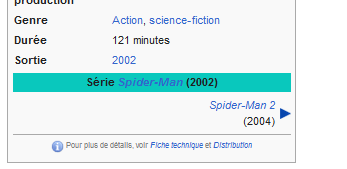

The work flow is to look at the movie in the English version -> convert it to the french version -> find the next movie and transfer to the french version of this movie -> convert it to the English version and retrieve the movie's name.

I must say sometimes the search in Wikipedia did not get the desired results so I will double check the results after using the similarity check function.

In [10]:
def change_lang(page_url:str,lang:str)->str:
    """
    page_url: URL of the page which we would like to find the link to a different language 
    lang:lang: which language are we looking e.g. - English
    return: URL link to the same wiki page in the desired language
    """
    response = urlopen(page_url)
    html_doc = response.read()
    soup = BeautifulSoup(html_doc, 'html.parser')
    l= soup.find_all("a", {"class": "interlanguage-link-target","lang":lang})
    return str(l).split('"')[3]

def change_to_next_movie(page_url:str)->str:
    """
    page_url: URL of the current page
    return: the URL of the next movie for page_url movie 
    """
    basic_fr_wiki_url = "https://fr.wikipedia.org/" # the basic URL for pages in french version of Wikipedia
    response = urlopen(page_url)
    html_doc = response.read()
    soup = BeautifulSoup(html_doc, 'html.parser')
    if soup.find("span", {"class": "prev_bloc"}): # if this is not the first movie (it has the previous movie) return Not first and None
        return ["not first",None]
    l = soup.find("span", {"class": "next_bloc"}) # if it has sequel return it 
    if l is None: #doesn't have "next_bloc" so we can't know if it has another movie
        return ["no next in wiki", None]
    return basic_fr_wiki_url+str(l).split('"')[3]

def get_title(url:str)->str:
    """
    url: the URL of the wiki page of the movie
    return: movie name (the title of the page...)
    """
    response = urlopen(url)
    html_doc = response.read()
    soup = BeautifulSoup(html_doc, 'html.parser')
    l = soup.find("title")
    return re.search('(?<=>).*(?= -)', str(l)).group()
    
def search_next_movie(movie_name:str)->list:
    """
    movie_name: name of the current row movie
    return: [found or not found(if not then why),name of the sequel movie]
    """
    wikipedia.set_lang("en") #set Wikipedia to english version
    shearches = wikipedia.search(movie_name +" film") # search the movie
    #Surrounded by a try statement because there can be a lot of problems when searching on Wikipedia. Therefore, if there is a problem, we will abandon this sample.
    try:
        page_url = wikipedia.page(shearches[0]).url
        page_url_fr= change_lang(page_url,"fr")
        next_movie_url_fr = change_to_next_movie(page_url_fr)
        if type(next_movie_url_fr)==list: # in case we don't get the URL it means we got a list that contains why this didn't work so return this reason
            return next_movie_url_fr
        next_movie_url_en = change_lang(next_movie_url_fr,"en")
    except:
        return ["many option/not found", None]
    return ["found",get_title(next_movie_url_en)]

# Run the script above over all the unknown movies 
wiki_next_movie  = [[movie_name]+search_next_movie(movie_name) for movie_name in unknowen_movies_df["movie_name"]]
wiki_next_movie_df = pd.DataFrame(wiki_next_movie, columns = ["movie_name","serach_status", 'next_movie_name_wiki'])

/opt/conda/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /opt/conda/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [11]:
found_names_movie = len(wiki_next_movie_df[~wiki_next_movie_df["next_movie_name_wiki"].isna()])
not_found =  len(wiki_next_movie_df[wiki_next_movie_df["serach_status"]=="many option/not found"])
not_first =len(wiki_next_movie_df[wiki_next_movie_df["serach_status"].isin(["no next in wiki","not first"])])
print("After scrapping from Wiki \nthe script found: {} names of sequels movies (just second), {} movies from the list that are not first movies or Wiki doesnt have the next one and didn't find at all {} movies".format(found_names_movie,not_first,not_found))

After scrapping from Wiki 
the script found: 13 names of sequels movies (just second), 76 movies from the list that are not first movies or Wiki doesnt have the next one and didn't find at all 24 movies


In [12]:
wiki_next_movie_df[~wiki_next_movie_df["next_movie_name_wiki"].isna()].sample(5)

,movie_name,serach_status,next_movie_name_wiki
32,The Collector,found,The Collection (film)
24,El Mariachi,found,Desperado (film)
0,The Shining,found,Doctor Sleep (2019 film)
36,Armour of God,found,Armour of God II: Operation Condor
69,The Da Vinci Code,found,Angels &amp; Demons (film)


As we can see we got some sequel movies. This is not perfect but it will help use to expand our sample size.

Because the results are not perfect, in the next cell we merge the movie's name and check, using the "similarity_check" function, if the result from Wikipedia is good (check if the next movie from IMDb is similraty to Wiki).

We will save only the results from Wiki that match the values of the column of the next movie.

In [13]:

# Merge the info from wiki to the unknowen df and filter to the found wiki names
unknowen_movies_df = pd.merge(unknowen_movies_df,wiki_next_movie_df,how="left",on="movie_name")

unknowen_movies_df= unknowen_movies_df[unknowen_movies_df["serach_status"]=="found"]

# Create a column without the generic words and with lower characters 
unknowen_movies_df["next_movie_name_wiki"] =unknowen_movies_df["next_movie_name_wiki"].str.lower().replace({"the":"","-":" ","'s":""},regex=True)

# Using the similarity_check find out the sequel relation movies
unknowen_movies_df["is_the_same_series"] = similarity_check(unknowen_movies_df["name_next_without_stop"],unknowen_movies_df["next_movie_name_wiki"],False)
unknowen_movies_df = unknowen_movies_df[unknowen_movies_df["is_the_same_series"]] 


unknowen_movies_df.loc[:,unknowen_movies_df.columns != 'second_movie'].sample(5)

,movie_name,year,next_movie,next_movie_year,name_without_stop,name_next_without_stop,is_the_same_series,serach_status,next_movie_name_wiki
74,Terms of Endearment,1983,The Evening Star,1996,terms of endearment,evening star,True,found,evening star
90,Anaconda,1997,Anacondas: The Hunt for the Blood Orchid,2004,anaconda,anacondas: hunt for blood orchid,True,found,anacondas: hunt for blood orchid
0,The Shining,1980,Doctor Sleep,2019,shining,doctor sleep,True,found,doctor sleep (2019 film)
82,The Silence of the Lambs,1991,Hannibal,2001,silence of lambs,hannibal,True,found,hannibal (2001 film)
36,Armour of God,1986,Operation Condor,1991,armour of god,operation condor,True,found,armour of god ii: operation condor


After making sure the movies from Wikipedia are good (coherent to the next movie by IMDb) we can continue to merge with verified movies that we found at the beginning.

In [14]:
# Concat with the first verified movies from the beginning
verefied_movies_df = pd.concat([verefied_movies_df,unknowen_movies_df]).reset_index(drop=True)[["movie_name","year","next_movie","next_movie_year"]]

# In case there is duplicates - drop them
verefied_movies_df.drop_duplicates(subset="movie_name",inplace=True)
verefied_movies_df

,movie_name,year,next_movie,next_movie_year
0,The Conjuring,2013,The Conjuring 2,2016
1,Angry Birds,2016,The Angry Birds Movie 2,2019
2,It,2017,It Chapter Two,2019
3,Zombieland,2009,Zombieland: Double Tap,2019
4,Frozen,2013,Frozen II,2019
...,...,...,...,...
367,Terms of Endearment,1983,The Evening Star,1996
368,The Silence of the Lambs,1991,Hannibal,2001
369,Anaconda,1997,Anacondas: The Hunt for the Blood Orchid,2004
370,Daredevil,2003,Elektra,2005


Now we will merge and get the full data for each movie - I used the startYear as well to merge because there are a lot of movies with the same name but there are no duplicates of movies with the same name and year.

In [15]:
first_movie = pd.merge(movies_df,verefied_movies_df,left_on=["primaryTitle","startYear"],right_on=["movie_name","year"])
second_movie = pd.merge(movies_df,verefied_movies_df,left_on=["primaryTitle","startYear"],right_on=["next_movie","next_movie_year"])
first_movie.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,movie_name,year,next_movie,next_movie_year
339,tt1937390,movie,Nymphomaniac: Vol. I,Nymphomaniac: Vol. I,0,2013,\N,117,Drama,6.9,124339,Nymphomaniac: Vol. I,2013,Nymphomaniac: Vol. II,2013
68,tt0099277,movie,Class of 1999,Class of 1999,0,1990,\N,99,"Action,Horror,Sci-Fi",5.9,7741,Class of 1999,1990,Class of 1999 II: The Substitute,1994
125,tt0120611,movie,Blade,Blade,0,1998,\N,120,"Action,Horror,Sci-Fi",7.1,272577,Blade,1998,Blade II,2002
298,tt1160368,movie,12 Rounds,12 Rounds,0,2009,\N,108,"Action,Crime,Thriller",5.6,29113,12 Rounds,2009,12 Rounds 2: Reloaded,2013
320,tt1457767,movie,The Conjuring,The Conjuring,0,2013,\N,112,"Horror,Mystery,Thriller",7.5,501896,The Conjuring,2013,The Conjuring 2,2016


In [16]:
print("After merging, the sample size of First Movies is {} and the sample size of the Sequel Movies is {}".format(len(first_movie),len(second_movie)))

After merging, the sample size of First Movies is 360 and the sample size of the Sequel Movies is 305


To summarize this part, I downloaded much of the information via web scrapping from a list of movies and sequels from IMDb, then I used the similarity function between the titles to differentiate between movies in a series and those from other series.
Finally, I used Wikipedia to verify those that I could not distinguish using the likelihood function.

<!-- ## A little EDA -->
<h2 id="A-little-EDA">A little EDA</h2>

The purpose of the project is not to analyze movies from IMDb so I will not explore and analyzie the movies deeply.

All I want to do is to show that the sample is diverse. For this, I will show the distribution over the years and across genres.


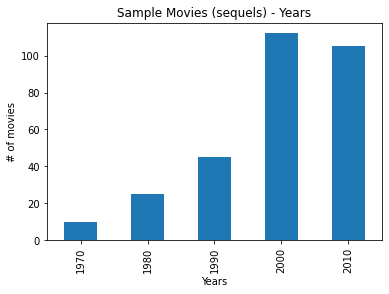

In [17]:
# Create new column with the decade the movie went out
second_movie["decade_myear_movie"]= (second_movie["startYear"].astype(int)//10)*10

# Order and count the movies by decade
movies_per_year = second_movie["decade_myear_movie"].value_counts()[second_movie["decade_myear_movie"].value_counts()>5].sort_index()

# Plot and cosmetics
movies_per_year.plot.bar()
plt.xlabel("Years")
plt.ylabel("# of movies")
plt.title ("Sample Movies (sequels) - Years")
plt.show()

As we can see we got pretty diverse movies over the years. This is a good sign that the sample is representative...

In the next plot, we will check the diversity of the movies in terms of genres.

Note that every movie has several genres, at the plot I count all the genres for each movie so the total bars are greater than the movie list.

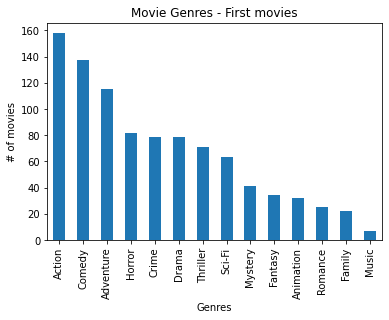

In [18]:
# Count the genres for all the movies (filter genres with more then 4)
geners_movie = pd.Series(chain(*first_movie["genres"].str.split(pat=","))).value_counts() 
geners_movie = geners_movie[geners_movie>4]

# Plot and cosmetics
geners_movie.plot.bar()
plt.xlabel("Genres")
plt.ylabel("# of movies")
plt.title ("Movie Genres - First movies")
plt.show()

As we can see, there is a good variety of genres of movies.

To sum up this part -  I showed that we have movies from diverse years and genres. It makes the project interfecne more reliable because the sample group is more representative.




<h2 id="Statisitcs-Interfecne">Statisitcs Interfecne</h2>


In this chapter, we will use statistical assumption testing.

We will start with an explnation of why the random variable is distributed as normal and to strenghthen the claim I will show the CDF (cumulative distribution function).

After this the assumption testing will be performed.

First of all, let's enter all the data into the table in order to have a clear view of the population

In [19]:
metrices_dict = {}
for movie_type,df in zip(["first movies","sequel movies","total movies"],[first_movie,second_movie,movies_df]):
    metrices_dict[movie_type] = [df["averageRating"].mean(), df["averageRating"].std(),len(df)]
metrices_df = pd.DataFrame.from_dict(metrices_dict).set_index(pd.Series(['mean',"std","len"]))
metrices_df

,first movies,sequel movies,total movies
mean,6.723333,6.101967,6.144323
std,1.006724,1.096224,1.348355
len,360.000000,305.000000,282596.000000


At first glance, it seems interesting: the mean of the first movies looks way higher than the sequels and the total movies.
Another thing is that the std is very similar in the first and the second movies (probably due to fewer samples than the total).

A good sign is the relatively good amount of samples in the first and sequel movies.

Let's start with the statistical interference in order to validate the difference between population.

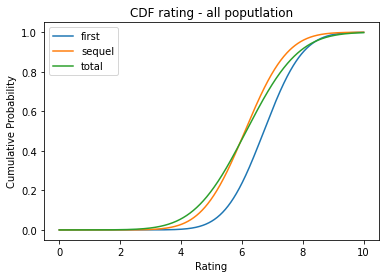

In [20]:
# Arrange the data to plot the CDF
x = np.linspace(0,10,1000)
y_list = [norm.cdf(x,metrices_df.loc["mean",assump],metrices_df.loc["std",assump]) for assump in ["first movies","sequel movies","total movies"]]

# Plot and cosmetices
for i in range(3):
    plt.plot(x,y_list[i])
plt.legend(["first","sequel","total"])
plt.xlabel("Rating")
plt.ylabel("Cumulative Probability")
plt.title ("CDF rating - all poputlation")
plt.show()


Actully we don't need the graph. CLT (Central limit thehorom) assures us that the random varibale of mean is converate to the normal distribution.
Even so, it is very elegant to see that the random variable of the different means is normaly distributed in the plot using the CDF. 

Notes -
1. I use the mean for each population  as the expectation using the Law of large numbers (mean -> expections)
2. I defined std of the distribution as the observed std using the fact that the MLE (Maximum likelihood estimation) for the variance of normal random variable is the observed std $\Sigma_{i=1}^{n}\frac{\left(x_{i}-\overline{x}\right)^{2}}{n-1}$.

Let's enter to the main issue-

I will check two assumptions.

1. The first is-

    Null Hypothesis- $\mu$ of total movies is equal to $\mu$ of first movies

    Counter Hypothesis - $\mu$ of total movies is lower than $\mu$ of first movies


2. the Second is-

    Null Hypothesis- $\mu$ of total movies is equal to $\mu$ of second movies

    Counter Hypothesis - $\mu$ of total movies is higher than $\mu$ of first movies

I will start by showing the power function for each test


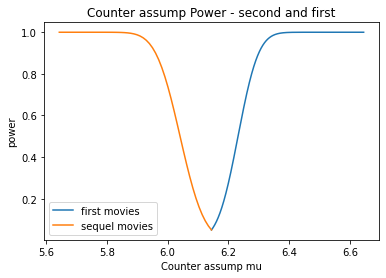

In [21]:
mean_total = metrices_df.loc["mean","total movies"]

# Calculate for both tests the power for each x point
# I added indicator to the y_power calcualtion ((assump == "sequel movies")*... and  (assump == "first movies")*... )
for assump in ["first movies","sequel movies"]:
    x_h1 = np.linspace(mean_total-0.5,mean_total) if assump=="sequel movies" else np.linspace(mean_total,mean_total+0.5,1000)
    y_power = norm.cdf(((mean_total-x_h1)/(metrices_df.loc["std",assump]/math.sqrt(metrices_df.loc["len",assump])))-(assump == "sequel movies")*norm.ppf(0.95, 0,1) + (assump == "first movies")*norm.ppf(0.95, 0,1))
    plt.plot(x_h1,y_power) if assump=="sequel movies" else plt.plot(x_h1,1-y_power) 

# Cosmetices of the plot
plt.legend(["first movies","sequel movies"])
plt.xlabel("Counter assump mu")
plt.ylabel("power")
plt.title ("Counter assump Power - second and first")
plt.show()


As we can see we've got a pretty good power to the test for a very little adjustment for the Counter Hypothesis.

To make this test clear let's try to find out what is the counter hypothesis with 0.8 power. 



In [22]:
coutr_seq_08,cuntr_first_08= [-((norm.ppf(prob, 0,1)+coeff*norm.ppf(0.95, 0,1))*(metrices_df.loc["std",assump]/math.sqrt(metrices_df.loc["len",assump])) - mean_total) for prob,coeff,assump in zip([0.8,0.2],[1,-1],["sequel movies","first movies"]) ]

print("The h1 for 0.8 power for the first movies is {} \nThe h1 for 0.8 power for the second movies is {} ".format(coutr_seq_08,cuntr_first_08))

The h1 for 0.8 power for the first movies is 5.988247622716795 
The h1 for 0.8 power for the second movies is 6.2762525292157685 


We can learn from these results that even a very low adjustment in the sequel movie (~0.3) from the total mean has 0.8 test power - which strengthened our test.

**To be honest, a counter hypothesis with a power of 0.8 that came out in the calculations is a hypothesis that seems very conservative.
We would expect good and bad movies to differ by at least a whole point or even a point and a half from normal movies.
The fact that our counter hypothesis is so strong for such a small difference (~0.3 and will grow as we move the counter hypothesis away) greatly strengthens our statistical test**.

Lets calculate the p-value for the tests*

\* I added in a comment another test that I performed following the large amount of observations of the general population, it does not exactly answer the research question but in my estimation strengthens the claim. Other than that it is stunningly beautiful. For more [see below](#other-test).

In [23]:
for assump in ["first movies","sequel movies"]:
    temp_mean,temp_std,temp_len  =[metrices_df.loc[metric,assump] for metric in ["mean","std","len"]]
    p_val =  norm.cdf((temp_mean-mean_total)/(temp_std/math.sqrt(temp_len)), 0, 1)
    p_val = 1- p_val if assump=="first movies" else p_val
    print("The p value for the {} assumption testing is {}".format(assump,p_val.round(4)))

The p value for the first movies assumption testing is 0.0
The p value for the sequel movies assumption testing is 0.2499


After getting the p-value for both tests we can see that we rejected the hypothesis that the $\mu$ of the first movies is the same as the total group. 

On the other hand, we can't reject the hypothesis that the second movies $\mu$ is lower than the total movies.

I will finish with the PDF (probability density function), after all the tests, it is very neat to see the difference between each population. 
As a matter of fact - the difference between the first movie to the other groups.

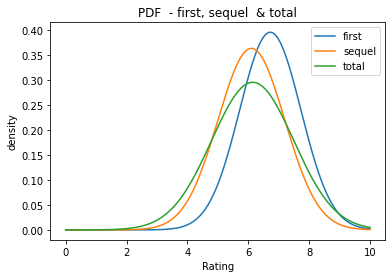

In [24]:
# Arrange the data to plot the CDF
x = np.linspace(0,10,1000)
y_list = [norm.pdf(x,metrices_df.loc["mean",group],metrices_df.loc["std",group]) for group in ["first movies","sequel movies","total movies"]]

# Plot and cosmetices
for i in range(3):
    plt.plot(x,y_list[i])
plt.legend(["first","sequel","total"])
plt.xlabel("Rating")
plt.ylabel("density")
plt.title ("PDF  - first, sequel  & total")
plt.show()

<h2 id="Summary">Summary</h2>


In conclusion, this work discusses the different populations of films.
Mainly, it focused on examining the difference between the first film of the series and the second in relation to the general population of films. The main part of the work concerned with collecting information and the statistical argument regarding the variations of the populations. It has been unequivocally shown that first films that have sequels are better than the rest of the population. On the other hand the sequels are not worse... They are just average.

Points for further research -
1. Carrying out a similar study but divide additional sub-populations into films that were previously determined to be a series.
2. Checking, if possible, that the phenomenon in question is regression to the mean.


<h4 id="other-test">A slightly different test</h4>
As written in the calculation of the p-value of the tets, there's an interest in calculating the CI of the entire group (because we have a big sample size) and test the assumption over this.

In the following cell I will show how the same result was achieved. 

I take random 500 rows from the total movies group and check if the mean of the second or first movies is contained in the CI. I repeat this 1000 times and at last I devide the total times that first and second movies mean showed, and then divide it by the times I make the simulation (to get the proportion).

This is a slightly different question because I take for granted the mean of the first and second groups (so this is a condition by that information). Even so, I believe it makes my statement more powerful. 

As mentioned before, the results agree with the previous tests conducted.

In [25]:
mean_first ,first_hyp= metrices_df.loc["mean","first movies"] ,0
mean_sequel,second_hyp = metrices_df.loc["mean","sequel movies"],0 
for i in range(10**3):
    random_movies = movies_df.sample(n = 500)["averageRating"]
    CI_95_total_movies = [random_movies.mean() + coef*norm.ppf(0.95, 0,1)*random_movies.std()/math.sqrt(len(random_movies)) for coef in [-1,1]]
    first_hyp += CI_95_total_movies[0] <mean_first< CI_95_total_movies[1]
    second_hyp += CI_95_total_movies[0] <mean_sequel< CI_95_total_movies[1]

print("The % of times that the mean of first movies was in the CI of the total movies is {}\nThe % of times that the mean of sequel movies was in the CI of the total movies is {}".format(first_hyp/10**3,second_hyp/10**3))


The % of times that the mean of first movies was in the CI of the total movies is 0.0
The % of times that the mean of sequel movies was in the CI of the total movies is 0.804
